In [ ]:
import scanpy as sc
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import pandas as pd
from statsmodels.stats.multitest import multipletests
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text


In [ ]:
# load single cell data
adata = sc.read_h5ad("cell_atlas_axicel_IP_scenic_tf_matrix_added_v2.h5ad")
#remove NA
adata = adata[~adata.obs['Response_3m'].isna()].copy()

# adata.X = (adata.X - 0.5) *2


In [ ]:
with open('./attention_weights/MIL_downstream_72_mil_results.pkl', 'rb') as f:
    mil_results = pickle.load(f)

In [ ]:
attn_weights = mil_results["attention_weights"]

all_attns = np.concatenate([np.hstack(attn_weights[p]).flatten() for p in attn_weights.keys()])


In [ ]:
# add attention score to the adata
adata.obs["attention"] = all_attns


In [ ]:
adata.obs["cell_annotation"].value_counts()

cell_annotation
CD8 T cell      17462
other T cell    10217
CD4 T cell       7946
DC                171
Mono               74
other              67
Name: count, dtype: int64

In [ ]:
# group "DC" and "Mono" as "Myeloid"
adata.obs["cell_annotation_myeloid"] = adata.obs["cell_annotation"]
adata.obs["cell_annotation_myeloid"] = adata.obs["cell_annotation_myeloid"].replace({"DC": "Myeloid", "Mono": "Myeloid"})

adata.obs["cell_annotation_myeloid"].value_counts()


/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_10322/2481103775.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["cell_annotation_myeloid"] = adata.obs["cell_annotation_myeloid"].replace({"DC": "Myeloid", "Mono": "Myeloid"})


cell_annotation_myeloid
CD8 T cell      17462
other T cell    10217
CD4 T cell       7946
Myeloid           245
other              67
Name: count, dtype: int64

# Calclate cell type enrichment (permutation test) based on mean expression

/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_46515/3458161851.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for patient_id, df_patient in tqdm(adata.obs.groupby('patient_id'), desc="Patients"):
Patients: 100%|██████████| 64/64 [00:18<00:00,  3.45it/s]
/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_46515/3458161851.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


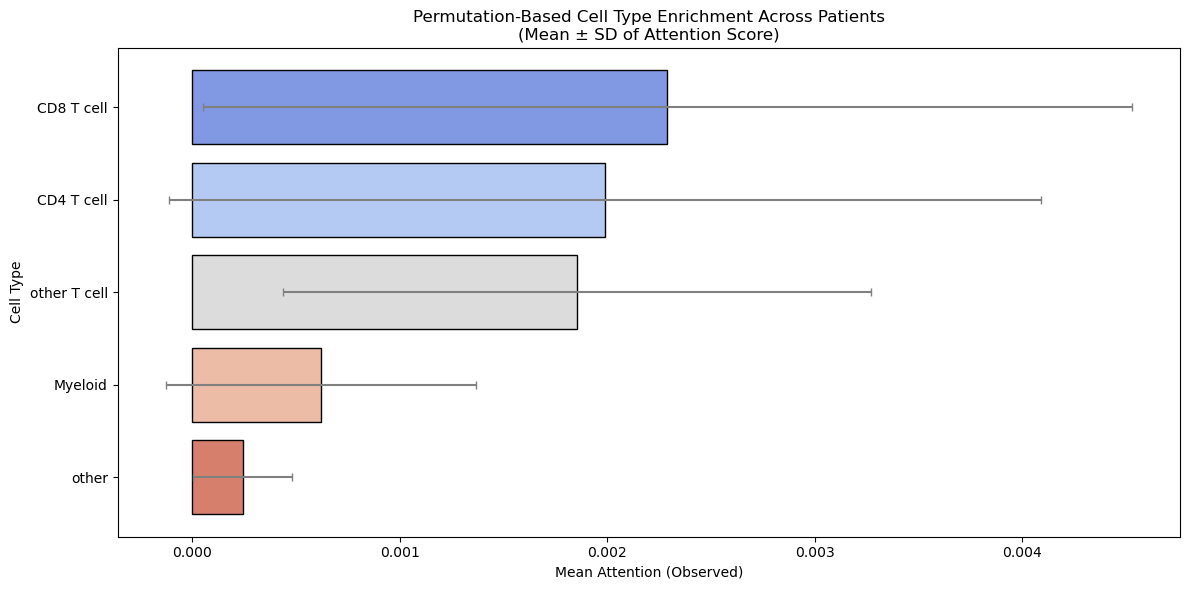

In [ ]:
# doing permutation testing - Original version
# one tailed test
# mean attention
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Parameters
n_permutations = 1000
min_cells = 3

# Containers
results = []

# Per-patient analysis
for patient_id, df_patient in tqdm(adata.obs.groupby('patient_id'), desc="Patients"):
    attention_scores = df_patient['attention'].copy()
    cell_types = df_patient['cell_annotation_myeloid'].copy()
    cell_ids = df_patient.index.tolist()

    for cell_type in cell_types.unique():
        # Indices of target cell type
        target_mask = cell_types == cell_type
        n_target = target_mask.sum()

        if n_target < min_cells:
            continue  # Skip rare types

        # Observed mean attention for this cell type
        obs_mean = attention_scores[target_mask].mean()

        # Generate null distribution by permuting labels
        null_means = []
        for _ in range(n_permutations):
            permuted_labels = np.random.permutation(cell_types)
            perm_mask = permuted_labels == cell_type
            perm_mean = attention_scores[perm_mask].mean()
            null_means.append(perm_mean)
            # perm_mask = permuted_labels[:n_target]
            # perm_mean = attention_scores[np.random.choice(cell_ids, size=n_target, replace=False)].mean()
            # null_means.append(perm_mean)

        null_means = np.array(null_means)



        # Compute empirical p-value
        p_emp = np.mean(null_means >= obs_mean)

        results.append({
            'patient_id': patient_id,
            'cell_type': cell_type,
            'obs_mean_attention': obs_mean,
            'null_mean': null_means.mean(),
            'p_emp': p_emp,
            'n_cells': n_target
        })

# Convert to DataFrame
df_perm_enrich = pd.DataFrame(results)

# Step 2: Summary across patients
summary_perm = df_perm_enrich.groupby('cell_type').agg(
    mean_attention=('obs_mean_attention', 'mean'),
    std_attention=('obs_mean_attention', 'std'),
    n_patients=('patient_id', 'nunique')
).reset_index().sort_values('mean_attention', ascending=False)

# Step 3: Plot summary
plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary_perm,
    y='cell_type',
    x='mean_attention',
    palette='coolwarm',
    orient='h',
    edgecolor='black'
)
plt.errorbar(
    summary_perm['mean_attention'],
    summary_perm['cell_type'],
    xerr=summary_perm['std_attention'],
    fmt='none',
    ecolor='gray',
    capsize=3
)
plt.xlabel('Mean Attention (Observed)')
plt.ylabel('Cell Type')
plt.title('Permutation-Based Cell Type Enrichment Across Patients\n(Mean ± SD of Attention Score)')
plt.tight_layout()
plt.show()


/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_46515/182291506.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_46515/182291506.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


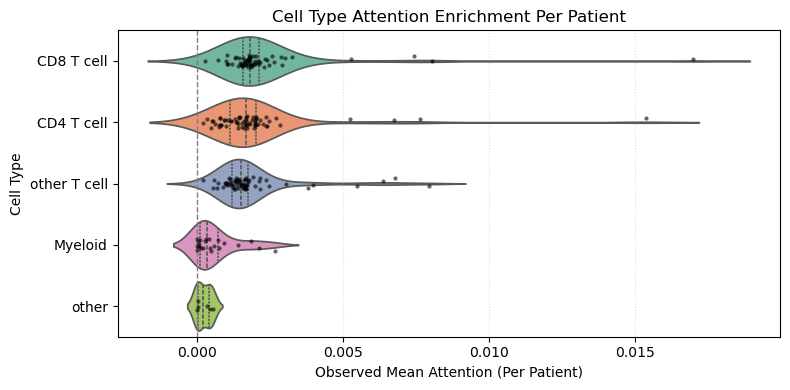

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use all available cell types
cell_types_ordered = (
    df_perm_enrich
    .groupby('cell_type')['obs_mean_attention']
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

df_plot = df_perm_enrich.copy()
df_plot['cell_type'] = pd.Categorical(df_plot['cell_type'], categories=cell_types_ordered, ordered=True)

# Create a more compact vertical violin plot
plt.figure(figsize=(8, max(4, len(cell_types_ordered) * 0.5)))  # Adjust height based on number of cell types

sns.violinplot(
    data=df_plot,
    y='cell_type',
    x='obs_mean_attention',
    inner='quartile',
    scale='width',
    palette='Set2'
)

sns.stripplot(
    data=df_plot,
    y='cell_type',
    x='obs_mean_attention',
    color='black',
    size=3,
    alpha=0.6,
    jitter=True
)

plt.xlabel("Observed Mean Attention (Per Patient)")
plt.ylabel("Cell Type")
plt.title("Cell Type Attention Enrichment Per Patient")
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.show()


# # Calclate cell type enrichment (permutation test) based on MEDIAN expression

/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_10322/2964824738.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for patient_id, df_patient in tqdm(adata.obs.groupby('patient_id'), desc="Patients"):
Patients: 100%|██████████| 64/64 [03:07<00:00,  2.93s/it]
/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_10322/2964824738.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


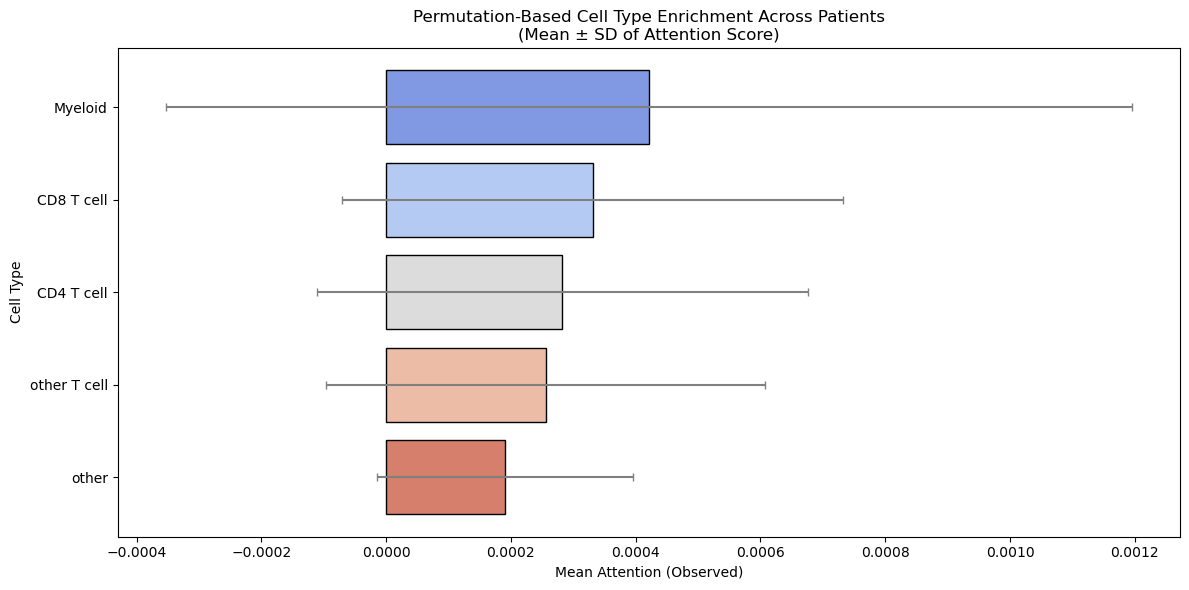

In [ ]:
#doing permutation testing Original version
# one tailed test
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Parameters
n_permutations = 10000
min_cells = 3

# Containers
results = []

# Per-patient analysis
for patient_id, df_patient in tqdm(adata.obs.groupby('patient_id'), desc="Patients"):
    attention_scores = df_patient['attention'].copy()
    cell_types = df_patient['cell_annotation_myeloid'].copy()
    cell_ids = df_patient.index.tolist()
    response = df_patient['Response_3m'].values[0]

    for cell_type in cell_types.unique():
        # Indices of target cell type
        target_mask = cell_types == cell_type
        n_target = target_mask.sum()

        if n_target < min_cells:
            continue  # Skip rare types

        # Observed mean attention for this cell type
        obs_median = attention_scores[target_mask].median()

        # Generate null distribution by permuting labels
        null_medians = []
        for _ in range(n_permutations):
            permuted_labels = np.random.permutation(cell_types)
            perm_mask = permuted_labels == cell_type
            perm_median = attention_scores[perm_mask].median()
            null_medians.append(perm_median)
            # perm_mask = permuted_labels[:n_target]
            # perm_mean = attention_scores[np.random.choice(cell_ids, size=n_target, replace=False)].mean()
            # null_means.append(perm_mean)

        null_medians = np.array(null_medians)



        # Compute empirical p-value
        p_emp = np.mean(null_medians >= obs_median)

        results.append({
            'patient_id': patient_id,
            'cell_type': cell_type,
            'obs_median_attention': obs_median,
            'null_median': null_medians.mean(),
            'p_emp': p_emp,
            'n_cells': n_target,
            'response': response
        })

# Convert to DataFrame
df_perm_enrich = pd.DataFrame(results)

# Step 2: Summary across patients
summary_perm = df_perm_enrich.groupby('cell_type').agg(
    mean_attention=('obs_median_attention', 'mean'),
    std_attention=('obs_median_attention', 'std'),
    n_patients=('patient_id', 'nunique')
).reset_index().sort_values('mean_attention', ascending=False)

# Step 3: Plot summary
plt.figure(figsize=(12, 6))
sns.barplot(
    data=summary_perm,
    y='cell_type',
    x='mean_attention',
    palette='coolwarm',
    orient='h',
    edgecolor='black'
)
plt.errorbar(
    summary_perm['mean_attention'],
    summary_perm['cell_type'],
    xerr=summary_perm['std_attention'],
    fmt='none',
    ecolor='gray',
    capsize=3
)
plt.xlabel('Mean Attention (Observed)')
plt.ylabel('Cell Type')
plt.title('Permutation-Based Cell Type Enrichment Across Patients\n(Mean ± SD of Attention Score)')
plt.tight_layout()
plt.show()


/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_10322/1593196732.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/vp/5l8hbb_542ddwt9hqsc4m7qc0000gp/T/ipykernel_10322/1593196732.py:19: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


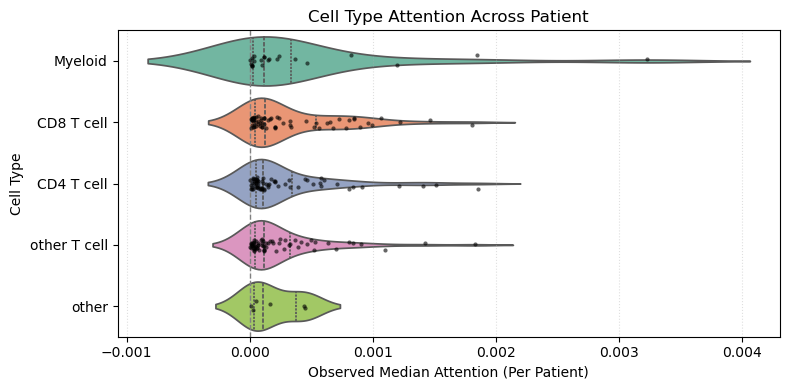

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use all available cell types
cell_types_ordered = (
    df_perm_enrich
    .groupby('cell_type')['obs_median_attention']
    .mean()
    .sort_values(ascending=False)
    .index.tolist()
)

df_plot = df_perm_enrich.copy()
df_plot['cell_type'] = pd.Categorical(df_plot['cell_type'], categories=cell_types_ordered, ordered=True)

# Create a more compact vertical violin plot
plt.figure(figsize=(8, max(4, len(cell_types_ordered) * 0.5)))  # Adjust height based on number of cell types

sns.violinplot(
    data=df_plot,
    y='cell_type',
    x='obs_median_attention',
    # hue='response',
    inner='quartile',
    scale='width',
    palette='Set2'
)

sns.stripplot(
    data=df_plot,
    y='cell_type',
    x='obs_median_attention',
    # hue='response',
    color='black',
    size=3,
    alpha=0.6,
    jitter=True
)

plt.xlabel("Observed Median Attention (Per Patient)")
plt.ylabel("Cell Type")
plt.title("Cell Type Attention Across Patient")
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle=':', alpha=0.4)
plt.tight_layout()
plt.savefig('/Users/kristintsui/HA_MIL_model/BioX_poster/cell_type_enrichment_10000permutations_3cell_min.pdf', format='pdf')
plt.show()


In [ ]:
from scipy.stats import chi2
import numpy as np

def fishers_method(p_values):
    """Combine p-values using Fisher's method"""
    # Remove any NaN values
    p_values = p_values[~np.isnan(p_values)]
    if len(p_values) == 0:
        return np.nan
    
    # Fisher's combined test statistic
    chi2_stat = -2 * np.sum(np.log(p_values + 1e-10))
    df = 2 * len(p_values)
    combined_p = 1 - chi2.cdf(chi2_stat, df)
    return combined_p

# Apply to your results
meta_results = df_perm_enrich.groupby('cell_type').agg(
    combined_p_fisher=('p_emp', fishers_method),
    mean_attention=('obs_median_attention', 'median'),
    n_patients=('patient_id', 'nunique')
).reset_index()

In [ ]:
from statsmodels.stats.multitest import multipletests

# Apply FDR correction
_, p_adjusted, _, _ = multipletests(meta_results['combined_p_fisher'], 
                                  method='fdr_bh', alpha=0.05)
meta_results['p_adjusted'] = p_adjusted
meta_results

,cell_type,combined_p_fisher,mean_attention,n_patients,p_adjusted
0,CD4 T cell,0.785927,0.000106,64,0.785927
1,CD8 T cell,0.000000,0.000127,64,0.000000
2,Myeloid,0.191521,0.000115,22,0.319202
3,other,0.780193,0.000108,6,0.785927
4,other T cell,0.020802,0.000114,64,0.052005


In [ ]:
df_perm_enrich

,patient_id,cell_type,obs_median_attention,null_median,p_emp,n_cells,response
0,01,other T cell,0.000499,0.000766,0.9160,237,OR
1,01,CD4 T cell,0.000916,0.000767,0.2681,134,OR
2,01,CD8 T cell,0.000781,0.000766,0.4949,229,OR
3,02,CD8 T cell,0.000459,0.000482,0.8816,217,OR
4,02,CD4 T cell,0.000466,0.000481,0.7442,193,OR
...,...,...,...,...,...,...,...
215,ac38,other T cell,0.000026,0.000026,0.2672,98,NR
216,ac38,CD4 T cell,0.000023,0.000026,0.9998,80,NR
217,ac39,CD4 T cell,0.000104,0.000128,0.9800,191,OR
218,ac39,CD8 T cell,0.000226,0.000128,0.0000,231,OR


In [ ]:
df_perm_enrich.groupby('cell_type').agg(
    mean_null_attention=('null_median', 'mean'),
    n_patients=('patient_id', 'nunique')
).reset_index()

,cell_type,mean_null_attention,n_patients
0,CD4 T cell,0.000314,64
1,CD8 T cell,0.000294,64
2,Myeloid,0.000646,22
3,other,0.000467,6
4,other T cell,0.000300,64


In [ ]:
from scipy.stats import wilcoxon

def wilcoxon_enrichment_test(df_perm_enrich):
    """Test cell type enrichment using Wilcoxon signed-rank test"""
    results = {}
    
    # Calculate population median for reference
    # pop_median = df_perm_enrich['obs_median_attention'].median()
    
    for cell_type in df_perm_enrich['cell_type'].unique():
        cell_data = df_perm_enrich[df_perm_enrich['cell_type'] == cell_type]
        
        if len(cell_data) < 3:  # Need sufficient patients
            continue
            
        pop_median = cell_data['null_median'].median()
        # Test if attention scores differ from population median
        differences = cell_data['obs_median_attention'] - pop_median
        
        # Remove zeros (no difference)
        non_zero_diffs = differences[differences != 0]
        
        if len(non_zero_diffs) == 0:
            results[cell_type] = {'statistic': 0, 'p_value': 1.0}
            continue
            
        try:
            statistic, p_value = wilcoxon(non_zero_diffs, alternative='two-sided')
            results[cell_type] = {
                'statistic': statistic,
                'p_value': p_value,
                'median_diff': differences.median(),
                'n_patients': len(cell_data)
            }
        except:
            results[cell_type] = {'statistic': np.nan, 'p_value': np.nan}
    
    return non_zero_diffs, pd.DataFrame(results).T

In [ ]:
diff,results = wilcoxon_enrichment_test(df_perm_enrich)
results

,statistic,p_value,median_diff,n_patients
other T cell,840.0,0.181059,-0.000010,64.0
CD4 T cell,866.0,0.244576,-0.000019,64.0
CD8 T cell,676.0,0.014923,0.000003,64.0
Myeloid,57.0,0.022916,-0.000515,22.0
other,3.0,0.156250,-0.000215,6.0


In [ ]:
for cell_type in df_perm_enrich['cell_type'].unique():
        cell_data = df_perm_enrich[df_perm_enrich['cell_type'] == cell_type]
        
        if len(cell_data) < 3:  # Need sufficient patients
            continue
            
        pop_median = cell_data['null_median'].median()
        # Test if attention scores differ from population median
        differences = cell_data['obs_median_attention'] - pop_median
        print(len(differences))
        break

64


In [ ]:
# If you just want adjusted p-values
results['p_adjusted'] = multipletests(results['p_value'], method='fdr_bh')[1]
results

,statistic,p_value,median_diff,n_patients,p_adjusted
other T cell,840.0,0.181059,-0.000010,64.0,0.226324
CD4 T cell,866.0,0.244576,-0.000019,64.0,0.244576
CD8 T cell,676.0,0.014923,0.000003,64.0,0.057291
Myeloid,57.0,0.022916,-0.000515,22.0,0.057291
other,3.0,0.156250,-0.000215,6.0,0.226324


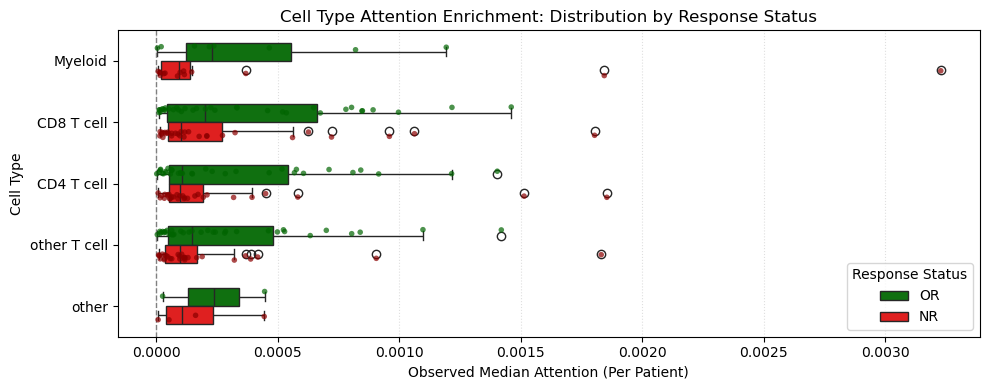

In [ ]:
plt.figure(figsize=(10, max(4, len(cell_types_ordered) * 0.6)))

# Create box plots
sns.boxplot(
    data=df_plot,
    y='cell_type',
    x='obs_median_attention',
    hue='response',
    palette=['green', 'red'],
    dodge=True,
    width=0.6
)

# Add individual points
sns.stripplot(
    data=df_plot,
    y='cell_type',
    x='obs_median_attention',
    hue='response',
    palette=['darkgreen', 'darkred'],  # Slightly darker for contrast
    size=4,
    alpha=0.7,
    jitter=True,
    dodge=True
)

plt.xlabel("Observed Median Attention (Per Patient)")
plt.ylabel("Cell Type")
plt.title("Cell Type Attention Enrichment: Distribution by Response Status")
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle=':', alpha=0.4)

# Clean legend
handles, labels = plt.gca().get_legend_handles_labels()
n_labels = len(df_plot['response'].unique())
plt.legend(handles[:n_labels], labels[:n_labels], title='Response Status', loc='lower right')

plt.tight_layout()
plt.show()

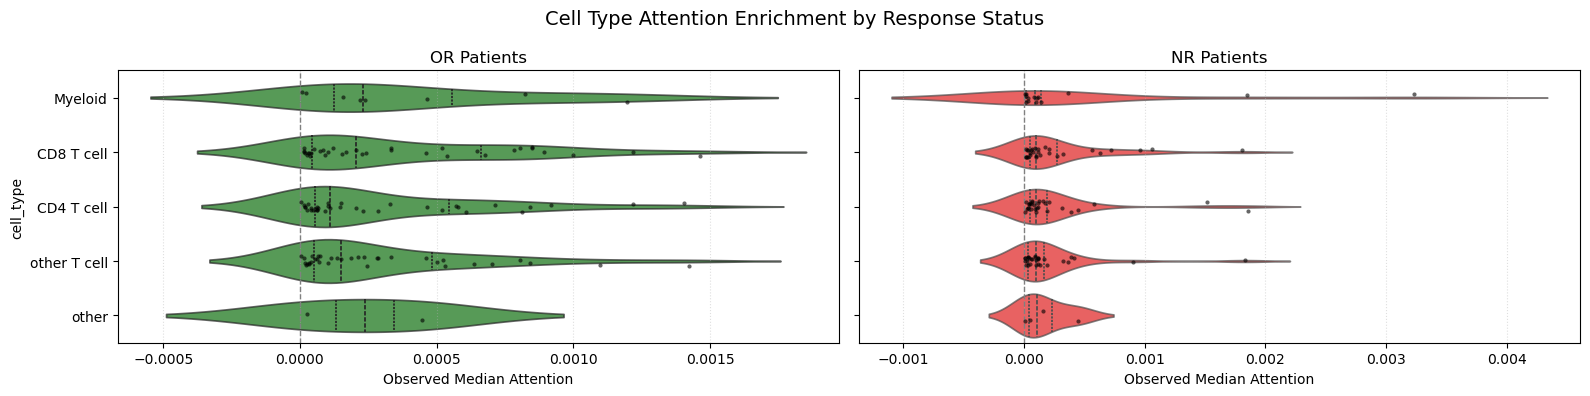

In [ ]:
# Create separate subplots for each response status
fig, axes = plt.subplots(1, 2, figsize=(16, max(4, len(cell_types_ordered) * 0.5)), sharey=True)

response_statuses = df_plot['response'].unique()
colors = ['green', 'red']

for i, (response, color) in enumerate(zip(response_statuses, colors)):
    subset_data = df_plot[df_plot['response'] == response]
    
    sns.violinplot(
        data=subset_data,
        y='cell_type',
        x='obs_median_attention',
        inner='quartile',
        color=color,
        alpha=0.7,
        ax=axes[i]
    )
    
    sns.stripplot(
        data=subset_data,
        y='cell_type',
        x='obs_median_attention',
        color='black',
        size=3,
        alpha=0.6,
        jitter=True,
        ax=axes[i]
    )
    
    axes[i].axvline(0, color='gray', linestyle='--', linewidth=1)
    axes[i].grid(axis='x', linestyle=':', alpha=0.4)
    axes[i].set_title(f'{response} Patients')
    axes[i].set_xlabel("Observed Median Attention")
    
    if i > 0:
        axes[i].set_ylabel("")

plt.suptitle("Cell Type Attention Enrichment by Response Status", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
df_perm_enrich

,patient_id,cell_type,obs_median_attention,null_median,p_emp,n_cells
0,01,other T cell,0.000499,0.000765,0.914,237
1,01,CD4 T cell,0.000916,0.000772,0.293,134
2,01,CD8 T cell,0.000781,0.000755,0.477,229
3,02,CD8 T cell,0.000459,0.000481,0.869,217
4,02,CD4 T cell,0.000466,0.000482,0.752,193
...,...,...,...,...,...,...
215,ac38,other T cell,0.000026,0.000026,0.257,98
216,ac38,CD4 T cell,0.000023,0.000026,0.996,80
217,ac39,CD4 T cell,0.000104,0.000129,0.987,191
218,ac39,CD8 T cell,0.000226,0.000128,0.000,231


In [ ]:
adata.obs['cell_annotation_myeloid'].value_counts()

cell_annotation_myeloid
CD8 T cell      17462
other T cell    10217
CD4 T cell       7946
Myeloid           245
other              67
Name: count, dtype: int64

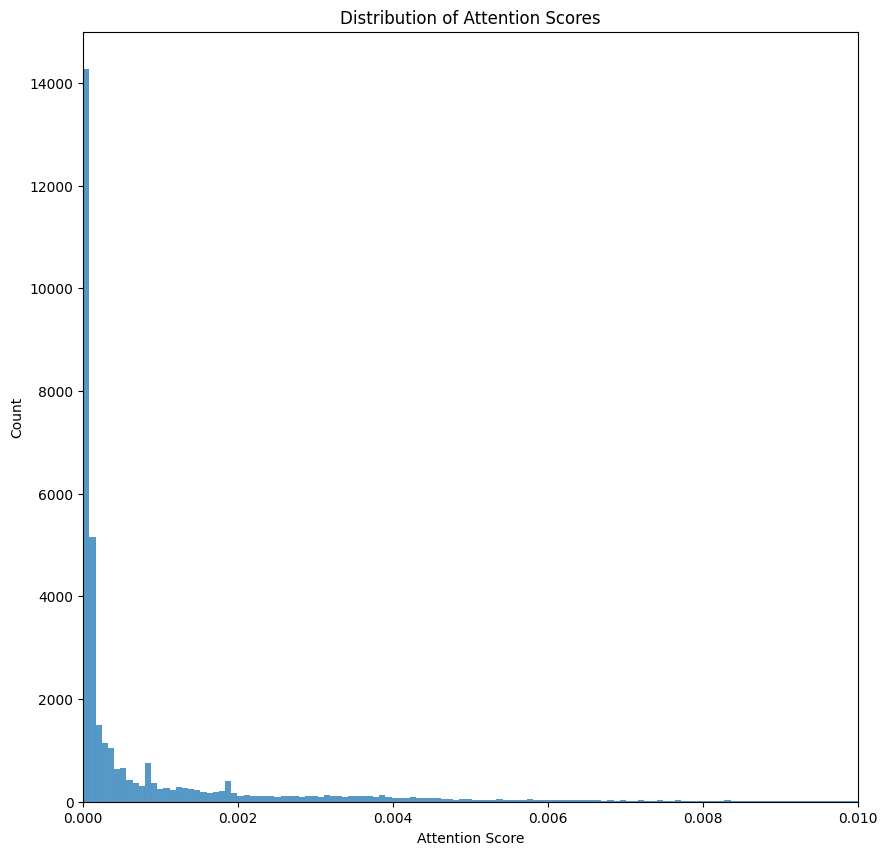

In [ ]:
# plot the distribution of the attention scores
plt.figure(figsize=(10, 10))
# Option 1: Kernel Density Estimation (KDE) plot
# sns.kdeplot(data=all_attns, fill=True)

# Option 2: Box plot
# sns.boxplot(y=all_attns)

# Option 3: Violin plot 
# sns.violinplot(y=all_attns)

# Option 4: Count plot with fewer bins
# sns.countplot(x=pd.qcut(all_attns, q=200))

# Option 5: Density plot with rug plot
# sns.displot(all_attns, kind='kde', rug=True)
sns.histplot(all_attns, bins=10000)
plt.xlim(0, 0.01)  # Adjust x-axis limits
plt.ylim(0, 15000)  # Adjust y-axis limits
plt.xlabel("Attention Score")
plt.ylabel("Count")
plt.title("Distribution of Attention Scores")
plt.show()
# plt.savefig("tcellMIL_attention_distribution.pdf", dpi=400, bbox_inches="tight")

In [ ]:
from scipy.stats import combine_pvalues

# Group by cell type and combine p-values using Fisher's method
pval_summary = (
    df_perm_enrich
    .groupby('cell_type')['p_emp']
    .apply(lambda pvals: combine_pvalues(pvals + 1e-10)[1])  # add small value to avoid log(0)
    .reset_index()
    .rename(columns={'p_emp': 'combined_p_value'})
    .sort_values('combined_p_value')
)

print(pval_summary)

      cell_type  combined_p_value
1    CD8 T cell      1.156088e-19
0    CD4 T cell      2.373019e-04
3          Mono      8.286088e-02
4         other      9.494224e-01
2            DC      9.897379e-01
5  other T cell      9.964852e-01


In [ ]:
df_perm_results

,patient_id,cell_type,obs_median_attention,null_median,p_two_tailed,p_greater,p_less,effect_size,n_cells,total_cells,p_corrected
0,01,other T cell,0.000499,0.000772,0.162,0.928,0.081,-1.516139,237,600,0.486
1,01,CD4 T cell,0.000916,0.000786,0.566,0.283,0.718,0.476665,134,600,0.849
2,01,CD8 T cell,0.000781,0.000771,1.012,0.506,0.516,0.058243,229,600,1.000
3,02,CD8 T cell,0.000459,0.000482,0.302,0.864,0.151,-1.077096,217,600,0.582
4,02,CD4 T cell,0.000466,0.000482,0.512,0.753,0.256,-0.743974,193,600,0.582
...,...,...,...,...,...,...,...,...,...,...,...
262,ac38,other T cell,0.000026,0.000026,0.524,0.262,0.739,0.695225,98,600,0.524
263,ac38,CD4 T cell,0.000023,0.000026,0.002,0.999,0.001,-2.779125,80,600,0.006
264,ac39,CD4 T cell,0.000104,0.000129,0.058,0.976,0.029,-1.814892,191,600,0.087
265,ac39,CD8 T cell,0.000226,0.000127,0.000,0.000,1.000,9.242590,231,600,0.000
